<h1 style="color:blue;">Personalized Movie Recommendation</h1>

# Business Problem:

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.


# Importing Libaries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle
from prettytable import PrettyTable
from tqdm import tqdm
import os
import datetime
from sklearn.preprocessing import StandardScaler

# Understanding the Data

## Quick Look at the data

__Loading the Data__

In [ ]:
movies  = pd.read_fwf(f'movies.dat',  encoding='ISO-8859-1')
ratings = pd.read_fwf(f'ratings.dat', encoding='ISO-8859-1')
users   = pd.read_fwf(f'users.dat',   encoding='ISO-8859-1')

__Data Dimension__

In [ ]:
print(f'movies  dimention --> {movies.shape}')
print(f'ratings dimention --> {ratings.shape}')
print(f'users   dimention --> {users.shape}')

movies  dimention --> (3883, 3)
ratings dimention --> (1000209, 1)
users   dimention --> (6040, 1)


__How the data looks like?__

In [ ]:
movies.sample(3)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
810,"821::Crude Oasis, The (1995)::Romance",NaN,NaN
361,365::Little Buddha (1993)::Drama,NaN,NaN
2334,2403::First Blood (1982)::Action,NaN,NaN


In [ ]:
ratings.sample(3)

,UserID::MovieID::Rating::Timestamp
90396,597::2908::5::975904423
137712,889::764::2::975261650
676655,4055::1944::4::965490398


In [ ]:
users.sample(3)

,UserID::Gender::Age::Occupation::Zip-code
1698,1699::F::25::19::98102
4032,4033::M::25::6::43551
5670,5671::M::25::1::02146


__Summary:__

- There are informations about 3883 movies, 6040 users, and 1000209 ratings
- The datasets, however, are not in usable format. The datasets requires fixing.

## Fixing Data

- We will format the data files to bring them into a workable format



In [ ]:
delimiter = '::'

**movies**

In [ ]:
movies.drop(columns=['Unnamed: 1', 'Unnamed: 2'], inplace=True)
movies = movies['Movie ID::Title::Genres'].str.split(delimiter, expand=True)
movies.columns = ['MovieID', 'Title', 'Genres']

In [ ]:
movies.sample(5)

,MovieID,Title,Genres
847,858,"Godfather, The (1972)",Action|Crime|Drama
224,227,Drop Zone (1994),Action
3106,3175,Galaxy Quest (1999),Adventure|Comedy|Sci-Fi
2357,2426,"Theory of Flight, The (1998)",Comedy|Drama|Romance
2963,3032,"Omega Man, The (1971)",Sci-Fi


In [ ]:
print(movies.shape)

(3883, 3)


**ratings**

In [ ]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimiter, expand=True)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [ ]:
ratings.sample(5)

,UserID,MovieID,Rating,Timestamp
281786,1690,3623,2,974714265
917931,5548,230,3,959481059
241711,1455,17,5,974757463
754427,4496,319,5,965014107
456519,2810,3176,3,1011318706


In [ ]:
ratings.shape

(1000209, 4)

**users**

In [ ]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimiter, expand=True)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

In [ ]:
users.sample(5)

,UserID,Gender,Age,Occupation,Zip-code
3316,3317,M,25,4,78705
433,434,F,45,3,98155
4993,4994,M,45,17,56001
3812,3813,M,35,7,80910
364,365,F,18,4,02138


In [ ]:
users.shape

(6040, 5)

__Summary:__

- The datasets for movies, users, and ratings are fixed
- movies has 3 columns, users has 5 columns, and ratings has 4 columns
- The attributes meaning are self-explanatory

## Merging Data

- We will merge the data files and create a single consolidated dataframe

**movies + ratings**

In [ ]:
df = pd.merge(movies, ratings, how='inner', on='MovieID')
df.head(3)

,MovieID,Title,Genres,UserID,Rating,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496


In [ ]:
df.shape

(1000209, 6)

**movies + ratings + users**

In [ ]:
df = pd.merge(df, users, how='inner', on='UserID')
df.head(3)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067


In [ ]:
df.shape

(1000209, 10)

__Summary:__

- The datasets have been merged into one single dataframe
- The final dataframe consists of 1000209 rows, and 10 columns. 

## Some basic checks


### Basic Summaries

**Shape of Data**

In [ ]:
print(f'No. of rows: {df.shape[0]}')
print(f'No. of columns: {df.shape[1]}')

No. of rows: 1000209
No. of columns: 10


__Column names:__

In [ ]:
df.columns

Index(['MovieID', 'Title', 'Genres', 'UserID', 'Rating', 'Timestamp', 'Gender',
       'Age', 'Occupation', 'Zip-code'],
      dtype='object')

__Checking the data types of the columns__

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  object
 1   Title       1000209 non-null  object
 2   Genres      996144 non-null   object
 3   UserID      1000209 non-null  object
 4   Rating      1000209 non-null  object
 5   Timestamp   1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  object
 8   Occupation  1000209 non-null  object
 9   Zip-code    1000209 non-null  object
dtypes: object(10)
memory usage: 83.9+ MB


__Summary__

- We have 1000209 rows, and 10 columns
- All the attributes are of type `object`


### Checking duplicate rows

In [ ]:
duplicate = df[df.duplicated(keep = 'last')]
duplicate

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code


__Findings:__
- There are no duplicate rows in the dataset

### Fixing any discrepansies in dtype

In [ ]:
df.select_dtypes('object').sample(3)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
510064,3408,Erin Brockovich (2000),Drama,5319,3,988241548,M,18,17,94941
881318,36,Dead Man Walking (1995),Drama,2726,5,973268131,M,45,11,02155
172120,2796,Funny Farm (1988),Comedy,1737,4,974707313,M,35,20,46614


In [ ]:
df.describe(include='object')

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
count,1000209,1000209,996144,1000209,1000209,1000209,1000209,1000209,1000209,1000209
unique,3706,3706,358,6040,5,458455,2,7,21,3439
top,2858,American Beauty (1999),Comedy,4169,4,975528402,M,25,4,94110
freq,3428,3428,116691,2314,348971,30,753769,395556,131032,3802


__Findings:__
- We have informations for 3706 movies, 1000209 users, and 6040 users
- The movies varies across 358 different genres.
- Gender, Age, Occupation are very less number of unique values. We can treat them as "categorical" features
- "Rating" should be treated as number
- "Timestamp" feature is given as Unix timestamp. We will convert it to Datetime.


__Fixing the dtype:__

In [ ]:
df['Rating'] = df['Rating'].astype('int32')
df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='s')
df.sample(3)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime
8003,2797,Big (1988),Comedy|Fantasy,132,4,977428729,M,25,17,99709,2000-12-21 19:58:49
404764,2302,My Cousin Vinny (1992),Comedy,4140,4,965350724,M,25,0,32112,2000-08-04 00:58:44
300586,674,Barbarella (1968),Adventure|Sci-Fi,3272,3,971254935,M,35,0,08330,2000-10-11 09:02:15


__Summary__

- We fixed the incorrect datatypes

### Checking missing values

In [ ]:
def missing_val_overview(df):

    ## Creating Empty Data Frame
    data_info = pd.DataFrame(np.random.randn(0, 5) * 0,
                             columns=['No. of Rows with missing values',
                                      'No. of columns with zero missing cases',
                                      'No. of columns with >0 and <=50% missing cases',
                                      'No. of columns with >50% missing cases',
                                      'No. of columns with >90% missing cases'])

    ## Data Inofrmation
    data_info.loc[0, 'No. of Rows with missing values'] = df.isna().any(axis=1).sum()
    null_per = pd.DataFrame(df.isna().sum()/df.shape[0])
    null_per.columns = ['null_per']
    data_info.loc[0, 'No. of columns with zero missing cases']  = null_per[null_per.null_per == 0.0].shape[0] 
    data_info.loc[0, 'No. of columns with >0 and <=50% missing cases'] = null_per[(null_per.null_per <= 0.50) & (null_per.null_per > 0)].shape[0] 
    data_info.loc[0, 'No. of columns with >50% missing cases']  = null_per[null_per.null_per > 0.50].shape[0]
    data_info.loc[0, 'No. of columns with >90% missing cases']  = null_per[null_per.null_per > 0.90].shape[0]
    
    ## Transposing Data to get in consumable format
    data_info = data_info.transpose()
    data_info.columns = ['Value']
    data_info['Value'] = data_info['Value'].astype(int)

    return data_info

In [ ]:
missing_val_overview(df)

,Value
No. of Rows with missing values,4065
No. of columns with zero missing cases,10
No. of columns with >0 and <=50% missing cases,1
No. of columns with >50% missing cases,0
No. of columns with >90% missing cases,0


**Summary**
- There is missing values in 1 column

In [ ]:
df.isnull().sum()

MovieID          0
Title            0
Genres        4065
UserID           0
Rating           0
Timestamp        0
Gender           0
Age              0
Occupation       0
Zip-code         0
Datetime         0
dtype: int64

__Findings:__
- There is missing values in Genres.
- We will try to understand why the data is missing in the further analysis

# EDA

We did some surface scratching and found some basic details. Now we will do in depth exploration of the dataset and try to come up with some possible actionable insights.

In [ ]:
def make_categorical_plots(df, feature):
    """
    Method to make univariate categorical plot
    """

    # creating a figure composed of two matplotlib.Axes objects (ax_count and ax_pie)
    f, (ax_count, ax_pie) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    data = df[feature].value_counts()

    sns.countplot(data=df, x=feature, order=data.index, ax=ax_count)
    if len(data) > 8:
        ax_count.set_xticklabels(labels=data.index, rotation=70)

    for p in ax_count.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax_count.annotate('{}'.format(int(y)), (x.mean(), y), 
                ha='center', va='bottom')

    #customize plot
    params = {
        'autopct':'%.0f%%',
        'startangle': 90,
        'radius': 1,
        'wedgeprops': {'linewidth': 3},
        'explode': (0.01,)*df[feature].nunique(),
        'textprops': {'size': 'large'}
    }
    #create pie chart
    ax_pie.pie(data.values, labels = data.index, **params)
    plt.show()

## Univariate Analysis

In [ ]:
df.columns

Index(['MovieID', 'Title', 'Genres', 'UserID', 'Rating', 'Timestamp', 'Gender',
       'Age', 'Occupation', 'Zip-code', 'Datetime'],
      dtype='object')

### Gender

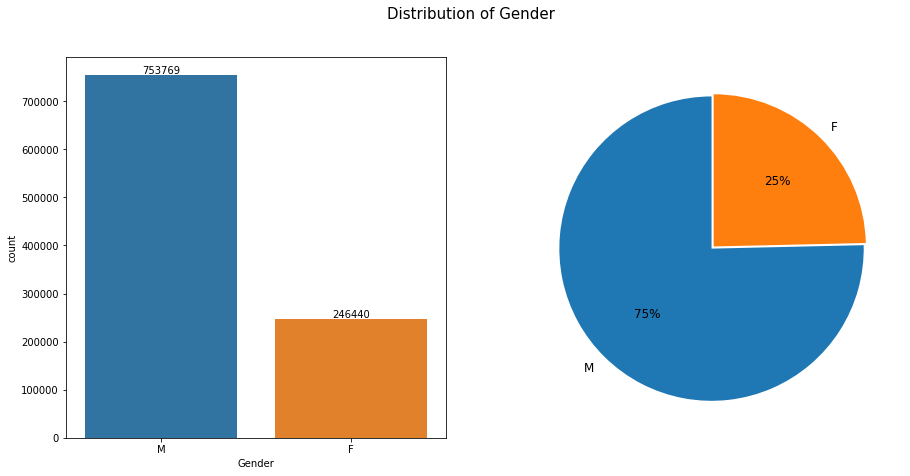

In [ ]:
make_categorical_plots(df, 'Gender')

__Findings__
- 75% of user base is Male
- Only 25% of the user base is Female


### Age

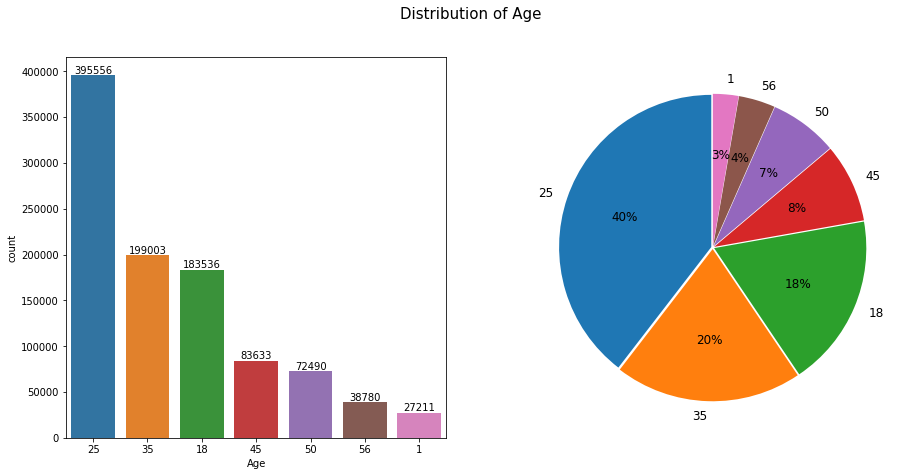

In [ ]:
make_categorical_plots(df, 'Age')

__Findings__
- 40% of the user base belongs to the age group "25-34". Followed by the age group "35-44" accounting 20% of the user base.
- The number of users below the age of 18 is very less.

### Occupation

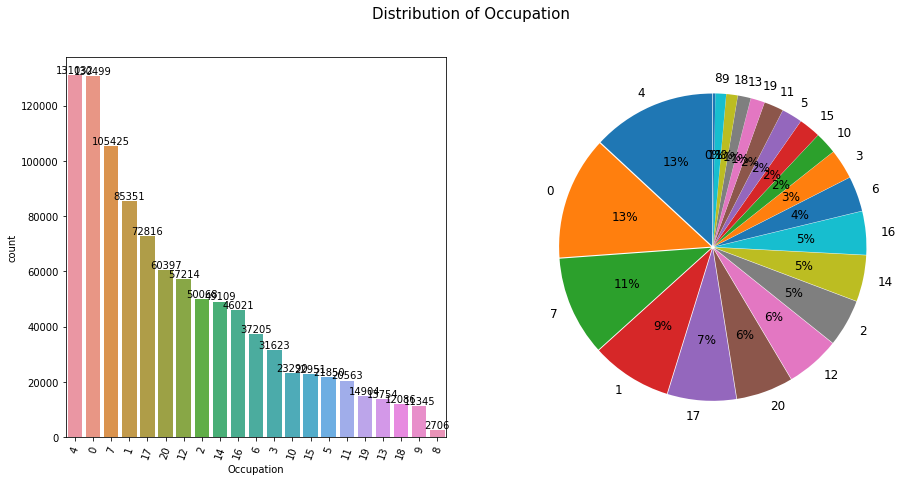

In [ ]:
make_categorical_plots(df, 'Occupation')

__Findings__
- Majority of the user base are the people with occupation as "college/grad student" and "other" or not specified
- "farmer" group has the lowest number of users

The mapping for occupation with their indexes are given below:


![](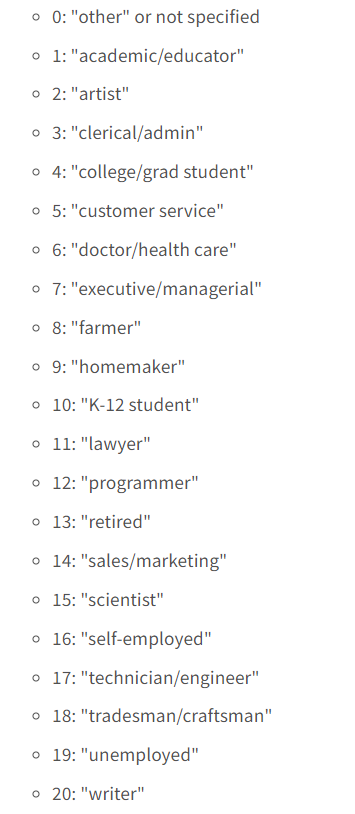)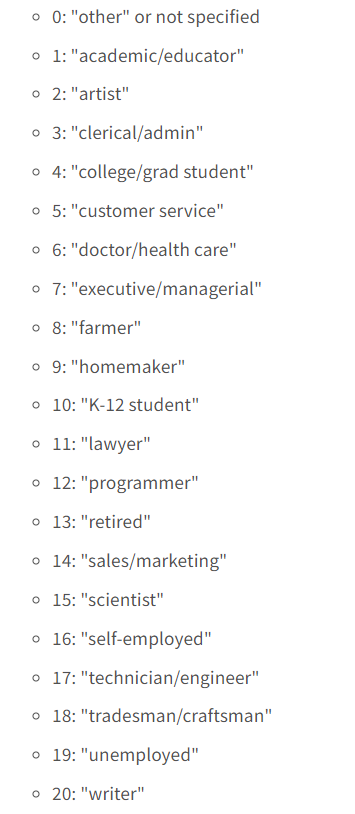

### Datetime

In [ ]:
df['Datetime'].describe()

count                 1000209
unique                 458455
top       2000-11-29 20:06:42
freq                       30
first     2000-04-25 23:05:32
last      2003-02-28 17:49:50
Name: Datetime, dtype: object

__Findings__
- Rating data is available from 2000-April-25 to 2003-Feb-28
- Highest number of ratings were given on 2000-Nov-29

### Rating

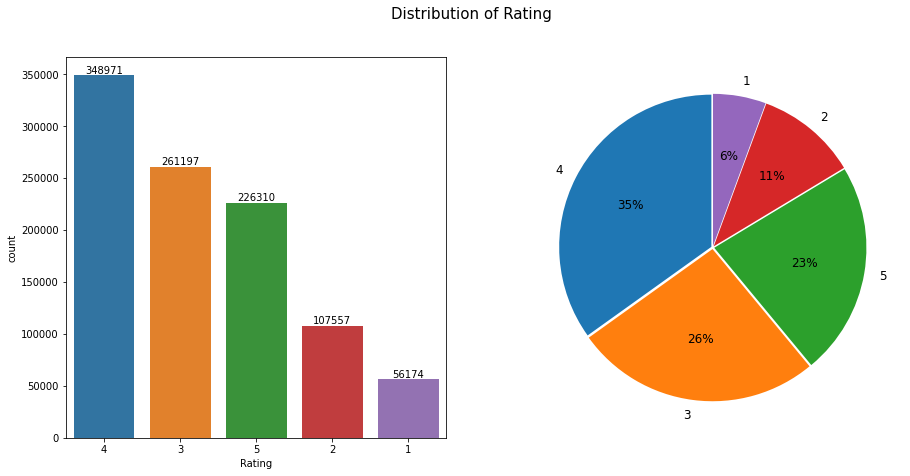

In [ ]:
make_categorical_plots(df, 'Rating')

__Findings__
- 35% of the times, a user rates a movie as 4 star
- Only 6% of the times, a user rates a movie as 1 star

### Title

In [ ]:
df['Title']

0                                   Toy Story (1995)
1                                  Pocahontas (1995)
2                                   Apollo 13 (1995)
3          Star Wars: Episode IV - A New Hope (1977)
4                            Schindler's List (1993)
                             ...                    
1000204                   Rules of Engagement (2000)
1000205                       American Psycho (2000)
1000206                     Keeping the Faith (2000)
1000207                                 U-571 (2000)
1000208                             Gladiator (2000)
Name: Title, Length: 1000209, dtype: object

__Findings__
- This attribute contains the names of the movies
- The Year of Release is also included in the title. We can extract the years and make some further analysis.

__Feature Extraction__

In [ ]:
import re
def get_year(x):
    try:
        m = x.rsplit(' ', 1)[1]
        return re.search('\d{4}', m).group()
    except:
        return None
        
get_year('Apollo 11 (2001)')

'2001'

In [ ]:
df['ReleaseYear'] = df['Title'].apply(get_year)
df[['Title', 'ReleaseYear']].sample(3)

,Title,ReleaseYear
42345,For a Few Dollars More (1965),1965
112719,"Few Good Men, A (1992)",1992
535491,"Lost World: Jurassic Park, The (1997)",1997


__Findings__
- We have extracted release years from the "Title"

__Analysis on ReleaseYear__

In [ ]:
df['ReleaseYear'].value_counts(dropna=False)

1999    86833
1998    68165
1997    65402
1995    60754
1996    59271
        ...  
1919       45
1929       43
1928       27
1920       24
1923       17
Name: ReleaseYear, Length: 82, dtype: int64

In [ ]:
nulls = df[df['ReleaseYear'].isna()]
nulls.head(3)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear
432,750,Dr. Strangelove or: How I Learned to Stop Worr...,None,10,4,979775386,F,35,1,95370,2001-01-17 23:49:46,None
708,3086,March of the Wooden Soldiers (a.k.a. Laurel & ...,None,10,4,978227574,F,35,1,95370,2000-12-31 01:52:54,None
945,2019,Seven Samurai (The Magnificent Seven) (Shichin...,None,18,5,978152973,F,18,3,95825,2000-12-30 05:09:33,None


In [ ]:
for item in nulls['Title'].unique():
    print(item)
    print('-'*30)

Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bo
------------------------------
March of the Wooden Soldiers (a.k.a. Laurel & Hardy in Toyland) (
------------------------------
Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (195
------------------------------
Don't Be a Menace to South Central While Drinking Your Juice in the
------------------------------
My Life and Times With Antonin Artaud (En compagnie d'Antonin Arta
------------------------------
Wonderful, Horrible Life of Leni Riefenstahl, The (Die Macht der B
------------------------------
Decline of Western Civilization Part II: The Metal Years, The (19
------------------------------
Lovers of the Arctic Circle, The (Los Amantes del Círculo Polar)
------------------------------
Garden of Finzi-Contini, The (Giardino dei Finzi-Contini, Il) (19
------------------------------
Swept Away (Travolti da un insolito destino nell'azzurro mare d'A
------------------------------
Went to Coney Island on a 

In [ ]:
df.isna().sum()

MovieID           0
Title             0
Genres         4065
UserID            0
Rating            0
Timestamp         0
Gender            0
Age               0
Occupation        0
Zip-code          0
Datetime          0
ReleaseYear    2570
dtype: int64

__Findings__
- It seems the Titles were trimmed after a certain length. Hence Year informations are not available in those Titles.
- We will remove these rows without any ReleaseYear

In [ ]:
df.dropna(subset=['ReleaseYear'], inplace=True)

__Binning the Release Years__

In [ ]:
print(df['ReleaseYear'].max())
print(df['ReleaseYear'].min())

2000
1919


In [ ]:
bins   = [1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009]
labels =    ['10s', '20s','30s','40s','50s','60s','70s','80s','90s', 'Millenium']

df['ReleaseDecade'] = pd.cut(df['ReleaseYear'].astype('int'), bins=bins, labels=labels)
df[['ReleaseYear', 'ReleaseDecade']].sample(3)

,ReleaseYear,ReleaseDecade
192868,1989,80s
17353,2000,Millenium
480859,1946,40s


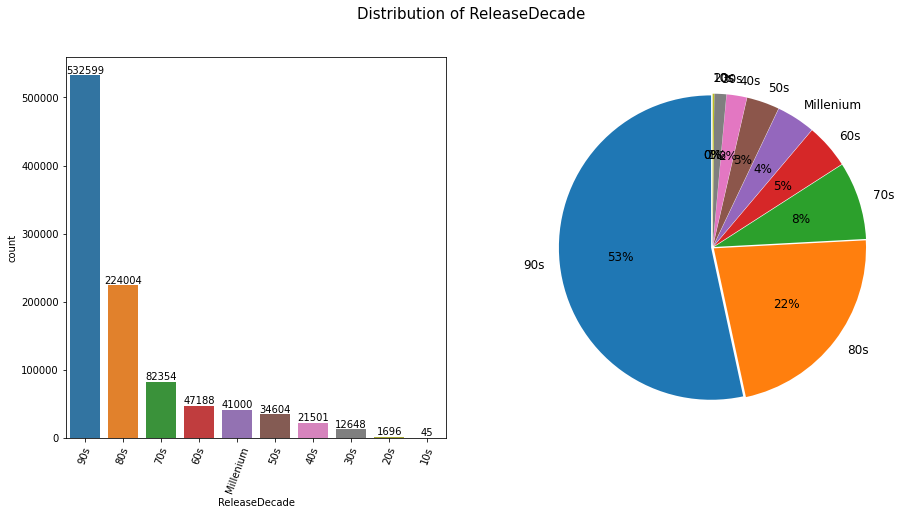

In [ ]:
make_categorical_plots(df, 'ReleaseDecade')

__Findings__
- Most of the movies in the platform are from 90's, followed by 80's
- The number of movie content from the older decades decreases as we go back on time
- The number of Millenium movies is less than 90s. This could be possibly due to the fact that Millenium has just started, and there are not many movies released so far.

__Cleaning the title__
- As there are years associated with all the movie names, we will remove them

In [ ]:
def get_title(x):
    return x.rsplit(' ', 1)[0]

get_title('Toy Story (1995)')

'Toy Story'

In [ ]:
df['Title'] = df['Title'].apply(get_title)
df[['Title']].sample(3)

,Title
448864,Sabrina
567223,Die Hard
649186,Glory


__Findings__
- We have removed Years from the titles

### Genres

In [ ]:
df['Genres']

0                   Animation|Children's|Comedy
1          Animation|Children's|Musical|Romance
2                                         Drama
3                       Action|Adventure|Fantas
4                                     Drama|War
                           ...                 
1000204                          Drama|Thriller
1000205                  Comedy|Horror|Thriller
1000206                          Comedy|Romance
1000207                         Action|Thriller
1000208                            Action|Drama
Name: Genres, Length: 997639, dtype: object

In [ ]:
df['Genres'].value_counts()[:10]

Comedy                     116691
Drama                      110955
Comedy|Romance              42193
Comedy|Drama                41676
Drama|Romance               28100
Action|Thriller             26759
Horror                      22216
Drama|Thriller              18248
Thriller                    17851
Action|Adventure|Sci-Fi     15712
Name: Genres, dtype: int64

__Findings__ 
- Most movies are a mix of multiple genres

In [ ]:
df.isna().sum()

MovieID             0
Title               0
Genres           1495
UserID              0
Rating              0
Timestamp           0
Gender              0
Age                 0
Occupation          0
Zip-code            0
Datetime            0
ReleaseYear         0
ReleaseDecade       0
dtype: int64

In [ ]:
df[df['Genres'].isna()].sample(3)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear,ReleaseDecade
327511,2790,"Final Conflict, The (a.k.a. Omen III: The Fina...",None,3491,4,967065348,M,25,16,28542,2000-08-23 21:15:48,1981,80s
593916,1150,"Return of Martin Guerre, The (Retour de Martin...",None,2319,4,974475761,M,35,7,48104,2000-11-17 15:42:41,1982,80s
70146,3070,Adventures of Buckaroo Bonzai Across the 8th D...,None,780,5,975436462,M,25,17,91776,2000-11-28 18:34:22,1984,80s


In [ ]:
df.dropna(inplace=True)

__Findings__
- There is no specific pattern in the data where Genre is missing
- As the Genres are also a mix of multiple genres, there is no straightforward way to impute them. Hence, dropping the rows with missing values.

## Gouping Data

**Average Rating**

In [ ]:
df.groupby('Title')['Rating'].mean().sort_values(ascending=False)

Title
Gate of Heavenly Peace, The                            5.0
Smashing Time                                          5.0
Bittersweet Motel                                      5.0
One Little Indian                                      5.0
Song of Freedom                                        5.0
                                                      ... 
Elstree Calling                                        1.0
Torso (Corpi Presentano Tracce di Violenza Carnale)    1.0
Waltzes from Vienna                                    1.0
Santa with Muscles                                     1.0
Windows                                                1.0
Name: Rating, Length: 3640, dtype: float64

__Findings__
- 'Gate of Heavenly Peace', 'Smashing Time', etc are some of the highly rated movies
- 'Windows', 'Santa with Muscles', etc are some of the lowest rated movies.


> However, the ratings can be misleading. Becuase a movie with a rating of 5 where only 2 users have rated, is not same as another movie who has the same rating but rated by thousands of users.
Hence, we should also check how many people rated the movie.

**Number of Ratings Given**

In [ ]:
df.groupby('Title')['Rating'].count().sort_values(ascending=False)

Title
American Beauty                                   3428
Star Wars: Episode IV - A New Hope                2991
Star Wars: Episode V - The Empire Strikes Back    2990
Star Wars: Episode VI - Return of the Jedi        2883
Jurassic Park                                     2672
                                                  ... 
Billy's Holiday                                      1
Voyage to the Beginning of the World                 1
Elstree Calling                                      1
Ten Benny                                            1
Nueba Yol                                            1
Name: Rating, Length: 3640, dtype: int64

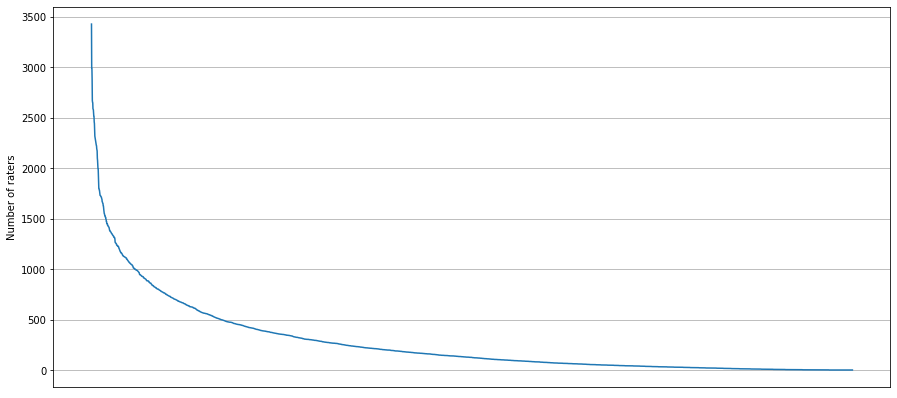

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df.groupby('Title')['Rating'].count().sort_values(ascending=False))
plt.xticks([], [])
plt.grid()
plt.ylabel('Number of raters')
plt.xlabel('')
plt.show()

__Findings__
- Movies like "American Beauty", "Star Wars", etc has been rated highly by users. We can rely on these ratings
- Movies like 'Nueba Yol', 'Ten Benny', etc has been rated by only one user. These ratings are not reliable. 

> We will drop the movies for whose the number of ratings is low. We will use 30 raters as the threshold.

In [ ]:
cnt_raters = df.groupby('Title')['Rating'].count().sort_values(ascending=False)
mv_names   = cnt_raters[cnt_raters < 30].index

In [ ]:
df[df['Title'].isin(mv_names)].shape

(9603, 13)

In [ ]:
df[df['Title'].isin(mv_names)]['Title'].nunique()

855

__Findings__
- We have around 855 movies with a low number of rater count
- These movies account for merely 0.9% of the data. Hence, we will remove them

In [ ]:
df = df[~df['Title'].isin(mv_names)]
df.shape

(986541, 13)

__Findings__
- Movies with low number of raters have been removed 

# Data Preparation

- Converting the data to a format that can be used for building Recommender Systems

In [ ]:
mat = pd.pivot_table(df, index='UserID', columns='Title', values='Rating', aggfunc='mean')
mat

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",187,...,You've Got Mail,Young Doctors in Love,Young Frankenstein,Young Guns,Young Guns II,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Your Friends and Neighbors,Zero Effect,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,4.0,NaN,...,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
mat.fillna(0, inplace=True)

In [ ]:
mat.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",187,...,You've Got Mail,Young Doctors in Love,Young Frankenstein,Young Guns,Young Guns II,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Your Friends and Neighbors,Zero Effect,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,4.0,0.0,...,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0


In [ ]:
mat.shape

(6040, 2785)

__Findings__
- The matrix contains UserID details along the y-direction, MovieID along the x-direction, and the cell values mean Rating for a particular (UserID, MovieID)

# Build a Recommender System

### Based on Pearson Correlation (Item Based)

- Here we will use the item-based approach to build a Recommender System

__Take User Input__

In [ ]:
user_input_movie = 'Liar Liar'

__Recommend Movies__

In [ ]:
movie_vector = mat[user_input_movie]

similar_movies = mat.corrwith(movie_vector)

In [ ]:
sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True)
sim_df.iloc[1:, :][:5]

,Correlation
Title,
Mrs. Doubtfire,0.499927
Dumb & Dumber,0.459601
Ace Ventura: Pet Detective,0.458654
Home Alone,0.455967
"Wedding Singer, The",0.429222


__Findings__

If the user like **`Liar Liar`**, the top 5 recommendations based on Pearson Correlation are:
- Mrs. Doubtfire (0.499927)
- Dumb & Dumber	(0.459601)
- Ace Ventura: Pet Detective (0.458654)
- Home Alone (0.455967)
- Wedding Singer, The (0.429222)

### Based on Cosine Similarity
- Here we will use the item-based approach to create a recommender system that uses Nearest Neighbors algorithm and Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

**User Similarity Matrix**

In [ ]:
user_similarity = cosine_similarity(mat)
user_sim_matrix = pd.DataFrame(user_similarity, index=mat.index, columns=mat.index)

In [ ]:
user_sim_matrix.head(3)

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.256071,0.123967,0.207800,0.143630,0.11032,0.121384,0.180497,0.103896,0.052816,...,0.079367,0.038048,0.032176,0.068074,0.070511,0.035731,0.170184,0.159267,0.122182,0.122444
10,0.256071,1.000000,0.260410,0.281306,0.164098,0.11325,0.142403,0.434465,0.195490,0.102789,...,0.154868,0.186783,0.084089,0.127093,0.119686,0.146984,0.305705,0.166188,0.136886,0.249292
100,0.123967,0.260410,1.000000,0.306067,0.078080,0.11045,0.358686,0.237850,0.172872,0.099147,...,0.098235,0.097953,0.065233,0.179835,0.273088,0.033754,0.344290,0.204302,0.116210,0.307071


**Item Similarity Matrix**

In [ ]:
item_similarity = cosine_similarity(mat.T)
item_sim_matrix = pd.DataFrame(item_similarity, index=mat.columns, columns=mat.columns)

In [ ]:
item_sim_matrix.head(3)

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",187,...,You've Got Mail,Young Doctors in Love,Young Frankenstein,Young Guns,Young Guns II,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Your Friends and Neighbors,Zero Effect,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.058619,0.189843,0.094785,0.058418,0.028171,...,0.096464,0.117695,0.123579,0.062942,0.062749,0.038725,0.076474,0.044074,0.039395,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.076798,0.137135,0.111413,0.046135,0.060254,...,0.085522,0.218780,0.129181,0.077667,0.037901,0.053010,0.087828,0.135962,0.074787,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.127895,0.128523,0.079115,0.066598,0.019914,...,0.154047,0.073955,0.048908,0.059325,0.049421,0.029200,0.062893,0.079187,0.079261,0.063284


**Create a CSR using the pivot table**

In [ ]:
from scipy import sparse

In [ ]:
# we are taking transpose because we want item info
csr_mat = sparse.csr_matrix(mat.T.values)
csr_mat

<2785x6040 sparse matrix of type '<class 'numpy.float64'>'
	with 983422 stored elements in Compressed Sparse Row format>

**Take User Input**

In [ ]:
user_input_movie = 'Good Will Hunting'

**Recommend Movies**

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(csr_mat)

NearestNeighbors(metric='cosine')

In [ ]:
distances, indices = knn.kneighbors(mat[user_input_movie].values.reshape(1, -1), n_neighbors=6)

In [ ]:
indices

array([[1062, 2253, 2036, 1343, 2270,  150]])

In [ ]:
print(f"Top 5 similar movies for {user_input_movie} are -->")

for idx in range(1, len(distances.flatten())):
    print(f"{idx}. {mat.columns[indices.flatten()[idx]]} ({distances.flatten()[idx]})")

Top 5 similar movies for Good Will Hunting are -->
1. Shawshank Redemption, The (0.36823061216497455)
2. Pulp Fiction (0.40795590248268376)
3. Jerry Maguire (0.4182340226678971)
4. Silence of the Lambs, The (0.42233950381716845)
5. Apollo 13 (0.4245223717634846)


__Findings__

If the user like **`Good Will Hunting`**, the top 5 recommendations for the user based on KNN + Cosine Distance are:
- Shawshank Redemption, The	(0.368)
- Pulp Fiction (0.4079)
- Jerry Maguire	(0.418)
- Silence of the Lambs (0.4223)
- Apollo 13	(0.4245)


### Based on Matrix Factorization

- We will create a Recommender System using the Matrix Factorization method using Deep Learning methods

In [6]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Flatten, dot
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import (
    mean_absolute_percentage_error as MAPE,
    mean_squared_error as MSE, 
    RootMeanSquaredError as RMSE
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

**Assign Unique Indexes to Users and Items**

In [7]:
unique_users  = df.UserID.unique()
unique_movies = df.MovieID.unique()

In [8]:
userid2idx  = {o:i for i, o in enumerate(unique_users)}
movieid2idx = {o:i for i, o in enumerate(unique_movies)}

In [9]:
df['UserID']  = df['UserID'].apply(lambda x: userid2idx[x])
df['MovieID'] = df['MovieID'].apply(lambda x: movieid2idx[x])

**Split the data to Train and Test**

In [10]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

**Defining the Model Architecture**

In [55]:
n_items  = len(unique_movies)
n_users  = len(unique_users)
n_latent_dim = 64
batch_size   = 128
epochs       = 30
validation_size = 0.2
learning_rate   = 0.1

In [56]:
K.clear_session()

# user layers
user_input     = Input(shape=(1, ), name='user_input', dtype='int64')
user_embedding = Embedding(n_users, n_latent_dim, name='user_embedding')(user_input)
user_vector    = Flatten(name='user_flat')(user_embedding)

# item layers
item_input     = Input(shape=(1, ), name='item_input', dtype='int64')
item_embedding = Embedding(n_items, n_latent_dim, name='item_embedding')(item_input)
item_vector    = Flatten(name='item_flat')(item_embedding)

# output
rating = dot([user_vector, item_vector], name='dot_product', axes=1)

# final model
model = Model([user_input, item_input], rating)

# compile model
model.compile(loss='mse', metrics=[RMSE('rmse'), 'mape'], optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 64)        386560      ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 64)        180864      ['item_input[0][0]']             
                                                                                              

**Train Model + Plots (Loss, RMSE, MAPE)**

In [44]:
# https://gist.github.com/danicrg/ab3bc7c330ce152bcf643231de4820e9#file-plot_learning_callback-py
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [57]:
plot_learning = PlotLearning()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.001)
callbacks = [plot_learning, reduce_lr]

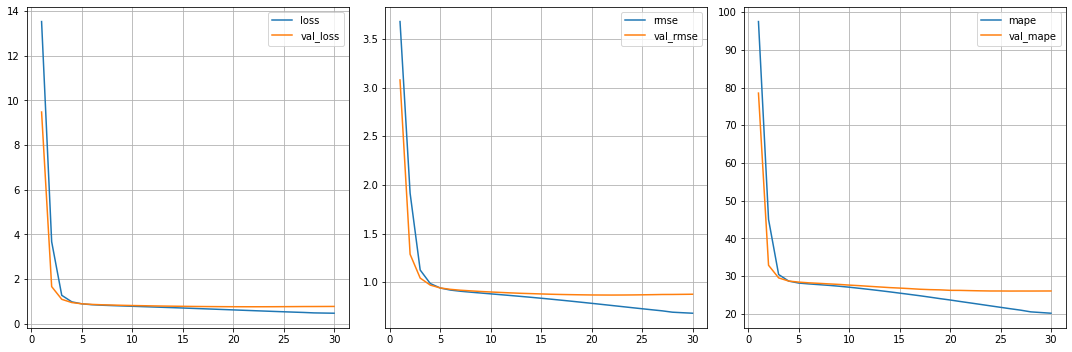

4625/4625 [==============================] - 15s 3ms/step - loss: 0.4644 - rmse: 0.6814 - mape: 20.1126 - val_loss: 0.7682 - val_rmse: 0.8765 - val_mape: 26.0142 - lr: 0.0500


In [58]:
history = model.fit(
    [df_train.UserID, df_train.MovieID], df_train.Rating,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks
)

**Results on Test Data**

In [69]:
mse_loss, rmse_score, mape_score = model.evaluate(
    x=[df_test.UserID, df_test.MovieID],
    y=df_test.Rating,
    batch_size=batch_size
)

1927/1927 [==============================] - 4s 2ms/step - loss: 0.7697 - rmse: 0.8773 - mape: 26.0151


In [72]:
print(f'Loss on Test Data --> {np.round(mse_loss, 3)}')
print(f'RMSE on Test Data --> {np.round(rmse_score, 3)}')
print(f'MAPE on Test Data --> {np.round(mape_score, 3)}')

Loss on Test Data --> 0.77
RMSE on Test Data --> 0.877
MAPE on Test Data --> 26.015


__Findings__
- The MAPE score on test data is 26.015
- The RMSE score is test data is 0.877

### Based on Pearson Correlation (User-Based)
- Here we will use the user-based approach to build a Recommender System

In [ ]:
from scipy.stats import pearsonr

**Ask the user to rate a few movies**

In [ ]:
movie_names = ['GoodFellas', 'Good Will Hunting', 'Home Alone', \
               'Pulp Fiction', 'Rain Man', 'Rambo III', 'Silence of the Lambs, The', \
               'Batman', 'Blade Runner', 'Lord of the Rings, The']

movie_ids = []
for movie in movie_names:
    id = df[df['Title'] == movie]['MovieID'].iloc[0]
    movie_ids.append(id)

print(movie_ids)

[158, 180, 327, 56, 33, 687, 245, 329, 323, 668]


In [ ]:
movie_ratings = [4, 5, 4, 5, 4, 3, 5, 2, 1, 4]

**Create dataframe for a new user's choice**

In [ ]:
user_choices = pd.DataFrame({
    'MovieID':  movie_ids,
    'Title'  : movie_names,
    'Rating' : movie_ratings
})
user_choices

,MovieID,Title,Rating
0,158,GoodFellas,4
1,180,Good Will Hunting,5
2,327,Home Alone,4
3,56,Pulp Fiction,5
4,33,Rain Man,4
5,687,Rambo III,3
6,245,"Silence of the Lambs, The",5
7,329,Batman,2
8,323,Blade Runner,1
9,668,"Lord of the Rings, The",4


**Find other users who’ve watched the same movies as the new user**

In [ ]:
other_users = df[df['MovieID'].isin(user_choices['MovieID'].values)]
other_users = other_users[['UserID', 'MovieID', 'Rating']]
other_users['UserID'].unique()

array([   0,    1,    2, ..., 6023, 6030, 6038])

In [ ]:
print(f"{other_users['UserID'].nunique()} users have watched the same movies as the new user")

4441 users have watched the same movies as the new user


**Sort the old users by the count of most movies in common with the new user**

In [ ]:
common_movies = other_users.groupby(['UserID'])
common_movies = sorted(common_movies, key = lambda x: len(x[1]), reverse=True)

In [ ]:
common_movies[0][1]

,UserID,MovieID,Rating
33948,141,56,5
34022,141,323,5
34030,141,327,3
34035,141,329,5
34036,141,245,5
34192,141,158,5
34362,141,180,3
34423,141,33,4
34508,141,668,4
34616,141,687,2


**Take the top 100 users and calculate a Similarity Score for each user using Pearson Correlation function**

In [ ]:
top_users = common_movies[:100]

pearson_results = {}

for user_id, movies in top_users:

    movie_list = movies['MovieID'].values

    new_user_ratings = user_choices[user_choices['MovieID'].isin(movie_list)].sort_values(by='MovieID')['Rating'].values
    user_ratings     = movies[movies['MovieID'].isin(movie_list)].sort_values(by='MovieID')['Rating'].values

    corr = pearsonr(new_user_ratings, user_ratings)
    pearson_results[user_id] = corr[0]


**Get top 10 users with the highest similarity indices**

In [ ]:
pearson_df = pd.DataFrame(columns= ['UserID', 'Similarity_Index'],
                          data   = pearson_results.items())
pearson_df = pearson_df.sort_values(by='Similarity_Index', ascending=False)[:10]
pearson_df

,UserID,Similarity_Index
73,3010,0.815385
97,541,0.809040
51,1225,0.750000
39,674,0.697676
93,494,0.674200
41,684,0.609641
72,2716,0.592999
16,2222,0.565217
20,158,0.553399
7,702,0.508689


**Get all the movies for these users and add Weighted movie Ratings by Multiplying the Rating to the Similarity Index**

In [ ]:
users_rating = pearson_df.merge(df, on='UserID', how='inner')
users_rating['Weighted_Rating'] = users_rating['Rating'] * users_rating['Similarity_Index']
users_rating = users_rating[['UserID', 'MovieID', 'Rating', 'Similarity_Index', 'Weighted_Rating']]
users_rating

,UserID,MovieID,Rating,Similarity_Index,Weighted_Rating
0,3010,587,3,0.815385,2.446156
1,3010,839,3,0.815385,2.446156
2,3010,114,5,0.815385,4.076926
3,3010,53,3,0.815385,2.446156
4,3010,840,2,0.815385,1.630770
...,...,...,...,...,...
9338,702,1787,2,0.508689,1.017379
9339,702,586,2,0.508689,1.017379
9340,702,831,2,0.508689,1.017379
9341,702,2485,1,0.508689,0.508689


**Add average recommendation score by dividing Weighted Rating by the Similarity Index. Then select movies with the highest score i.e., 5**

In [ ]:
grouped_ratings = users_rating.groupby('MovieID').sum()[['Similarity_Index', 'Weighted_Rating']]

recommend_movies = pd.DataFrame()

recommend_movies['Avg_Rec_Score'] = grouped_ratings['Weighted_Rating'] / grouped_ratings['Similarity_Index']
recommend_movies['MovieID'] = grouped_ratings.index
recommend_movies.reset_index(drop=True, inplace=True)

recommend_movies = recommend_movies[recommend_movies['Avg_Rec_Score'] == 5]
recommend_movies

,Avg_Rec_Score,MovieID
4,5.0,4
11,5.0,11
24,5.0,24
28,5.0,28
120,5.0,120
...,...,...
2509,5.0,2690
2513,5.0,2694
2548,5.0,2733
2553,5.0,2739


**Recommend 10 movies based on the ratings given by old users who are similar to the new user**

In [ ]:
recommendations = df[df['MovieID'].isin(recommend_movies['MovieID'])][['MovieID', 'Title']].sample(10)
recommendations

,MovieID,Title
593302,1333,Playing by Heart
265745,1676,Laura
278869,1900,"Bank Dick, The"
925949,4,Schindler's List
349609,2276,Paths of Glory
284686,185,Primary Colors
529817,1199,When We Were Kings
33040,1875,Carnal Knowledge
259918,11,Wallace & Gromit: The Best of Aardman Animation
49567,1590,On the Town
